# Regression wine sugar content
Here I used ANN to do regression on the column residual sugar. Here I tried 3 method:
1. original ANN
2. ANN with L2 regularizaion
3. ANN with dropout regularization.

It seems in this case specifically, depending on the run the results are different. It's hard to say which method produces better results. In this specific run, droput performs better. 

In [57]:
# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activations, optimizers)
### LECTURE: Activation functions comparison
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [58]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [59]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# data = pd.read_csv(url,sep=';')
# data

In [60]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore = cols2zscore.drop('residual sugar') 


# Re-organize the data: train/test in DataLoaders

In [61]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()
labels = labels[:,None] # transform to matrix

In [62]:
# use scikitlearn to split the data
train_data_ori,test_data_ori, train_labels_ori,test_labels_ori = train_test_split(dataT, labels, test_size=.3)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data_ori,train_labels_ori)
test_data  = torch.utils.data.TensorDataset(test_data_ori,test_labels_ori)

# finally, translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Now for the DL part

In [63]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self, n_units = 16, dropout_p = 0):
    super().__init__()
    self.dropout_p = dropout_p
    ### input layer
    self.input = nn.Linear(11,n_units)
    
    ### hidden layers
    self.fc1 = nn.Linear(n_units,n_units)

    ### output layer
    self.output = nn.Linear(n_units,1)
  
  # forward pass
  def forward(self,x):
    # here I added dropout layer but by default it's off since I set dropout_p to be 0
    x = torch.relu( self.input(x) )
    x = F.dropout(x, p = self.dropout_p, training=self.training)
    x = torch.relu( self.fc1(x) )
    x = F.dropout(x, p = self.dropout_p, training=self.training)
    return self.output(x)

# Train the model

In [64]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(l2_lambda=0):

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01, weight_decay=l2_lambda)

  # initialize losses
  losses   = torch.zeros(numepochs)
  train_loss = []
  test_loss  = []

  # loop over epochs
  for epochi in range(numepochs):

    # turn on training mode
    winenet.train()

    # loop over training data batches
    batch_loss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    train_loss.append( np.mean(batch_loss) )

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    test_loss.append( lossfun(yHat, y).item() )

    # get the R2 for train_hat and train, test_hat and test
    train_hat = winenet(train_data_ori)
    test_hat = winenet(test_data_ori)
    R2_train = np.corrcoef(train_hat.detach().T, train_labels_ori.detach().T)[0, 1]
    R2_test = np.corrcoef(test_hat.detach().T, test_labels_ori.detach().T)[0, 1]
  
  # function output
  return train_loss, test_loss, round(R2_train, 3), round(R2_test, 3)

R2_train is:  0.993 R2_test is:  0.797


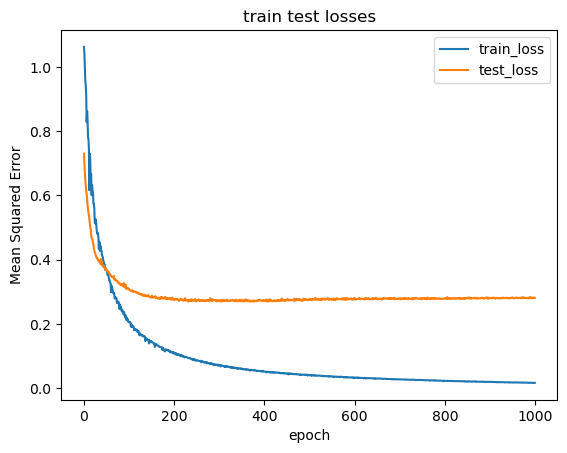

In [65]:
winenet = ANNwine(n_units=128)
train_loss, test_loss, R2_train, R2_test = trainTheModel()

print('R2_train is: ', R2_train, 'R2_test is: ', R2_test)
# plot some results. 
# it shows a lot of overfitting, since the train loss decreases but test loss increases. 
# So add L2 regularization and batch normalization 
plt.plot(train_loss, label = 'train_loss')
plt.plot(test_loss, label = 'test_loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.title('train test losses')
plt.legend()
plt.show()

### add L2 regularization to the model

R2_train is:  0.957 R2_test is:  0.796


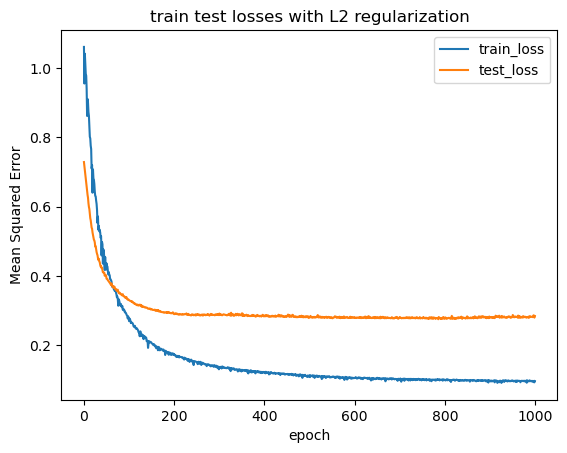

In [66]:
winenet = ANNwine(n_units=64)
train_loss, test_loss, R2_train, R2_test = trainTheModel(l2_lambda=0.01)

print('R2_train is: ', R2_train, 'R2_test is: ', R2_test)
# plot some results. 
# it shows a lot of overfitting, since the train loss decreases but test loss increases. 
# So add L2 regularization and batch normalization 
plt.plot(train_loss, label = 'train_loss')
plt.plot(test_loss, label = 'test_loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.title('train test losses with L2 regularization')
plt.legend()

plt.show()

### add dropout regularization to the model

R2_train is:  0.952 R2_test is:  0.824


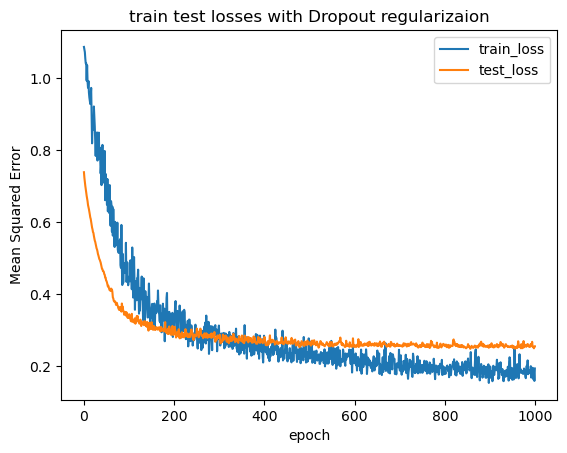

In [67]:
winenet = ANNwine(n_units=64, dropout_p=0.3)
train_loss, test_loss, R2_train, R2_test = trainTheModel()

print('R2_train is: ', R2_train, 'R2_test is: ', R2_test)
# plot some results. 
# it shows a lot of overfitting, since the train loss decreases but test loss increases. 
# So add L2 regularization and batch normalization 
plt.plot(train_loss, label = 'train_loss')
plt.plot(test_loss, label = 'test_loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.title('train test losses with Dropout regularizaion')
plt.legend()

plt.show()